In [26]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from al_util import *
from graph_util import *
import scipy.sparse as sparse
import pandas as pd

In [2]:
%load_ext autoreload

In [3]:
%autoreload

In [4]:
X, digits = gl.datasets.load('mnist', metric='vae')

In [5]:
W = gl.weightmatrix.knn(X, 20)
G = gl.graph(W)

In [22]:
deg = G.degree_vector()
deg = (deg - deg.min())/(deg.max() - deg.min())

In [7]:
evals, evecs = G.eigen_decomp(normalization='normalized', k=100, method='lowrank', q=150)

# Binary Test -- Odd vs Even

In [8]:
labels = digits.copy()
labels[labels % 2 == 0] = 0
labels[labels % 2 == 1] = 1

labeled_ind = gl.trainsets.generate(labels, 1)
c0_ind, c1_ind = labeled_ind[labels[labeled_ind] == 0], labeled_ind[labels[labeled_ind] == 1]

In [11]:
digit_sorted_idx = np.argsort(digits)
sorted_labels = labels[digit_sorted_idx]
sorted_labeled_ind = np.where(np.isin(digit_sorted_idx, labeled_ind))[0]

In [9]:
unlabeled_ind = np.delete(np.arange(labels.size), labeled_ind)

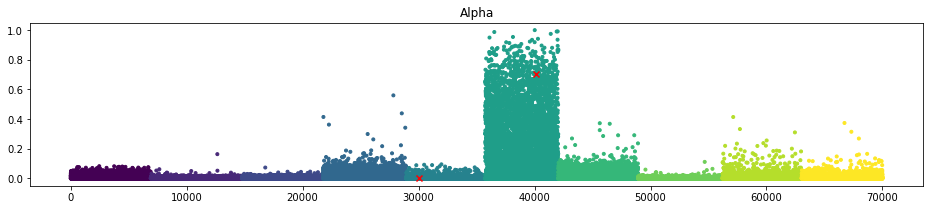

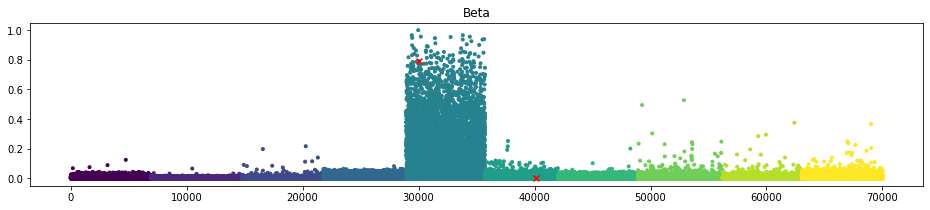

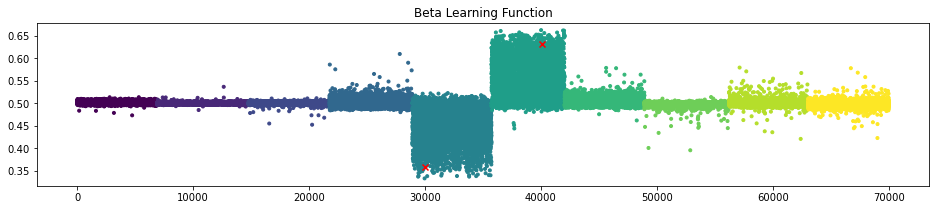

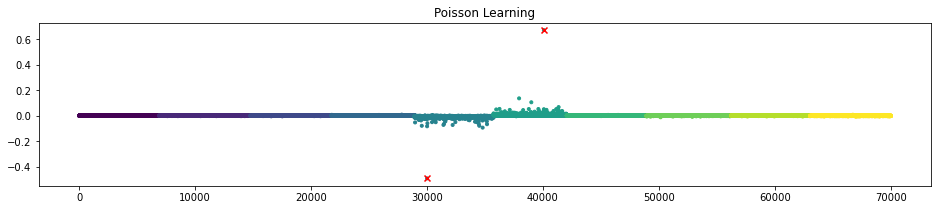

In [15]:
alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5

dom = np.arange(G.num_nodes)
train_ind = labeled_ind
sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]

fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, alpha[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, alpha[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Alpha")
plt.show()

fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, beta[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, beta[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Beta")
plt.show()

fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, p[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, p[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Beta Learning Function")
plt.show()

pl = gl.ssl.poisson(G)
u = pl.fit(train_ind, labels[train_ind])[:,-1]
fig, ax = plt.subplots(figsize=(16,3))
ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
ax.set_title(f"Poisson Learning")
plt.show()

## Active Learning Loop Test

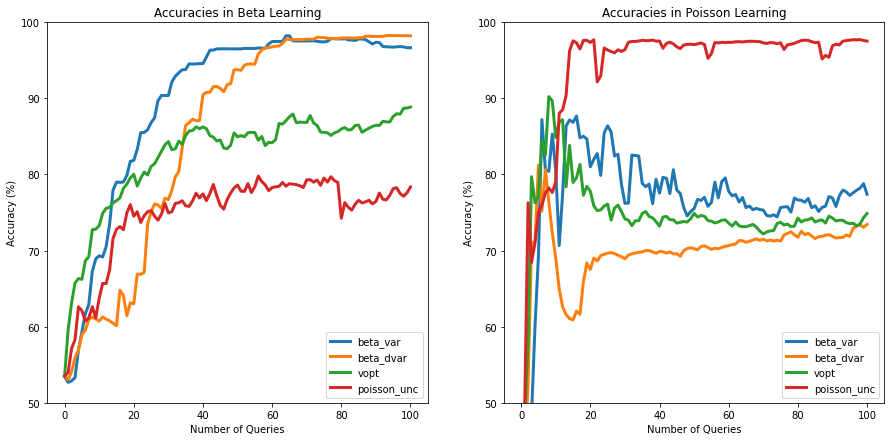

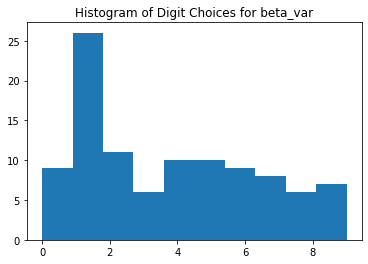

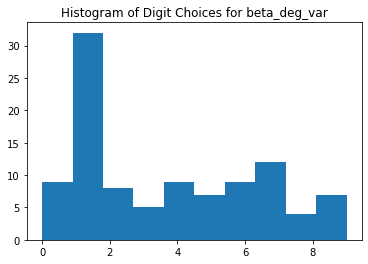

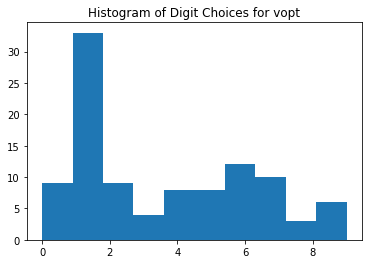

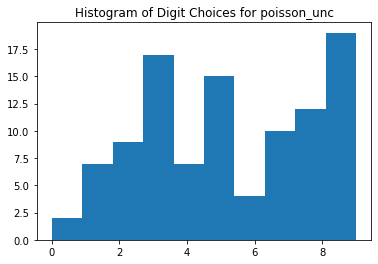

In [56]:
import os

if os.path.exists("Lnorm_query_choices.csv"):
    query_choices_df = pd.read_csv("Lnorm_query_choices.csv")
    poisson_df = pd.read_csv("Lnorm_poisson_acc.csv")
    beta_df = pd.read_csv("Lnorm_beta_acc.csv")
    labeled_ind = np.load("Lnorm_init_labeled.npy")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    beta_df.plot(ax=ax1, title='Accuracies in Beta Learning', linewidth=3.0)
    poisson_df.plot(ax=ax2, title='Accuracies in Poisson Learning', linewidth=3.0)
    ax1.set_xlabel("Number of Queries")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_ylim(50,100)
    ax1.legend(loc='lower right')
    ax2.set_xlabel("Number of Queries")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_ylim(50,100)
    ax2.legend(loc='lower right')
    plt.show()
    
    col_choices = [name for name in query_choices_df.columns if "_choices" in name]
    for col_name in col_choices:
        name = "_".join(col_name.split("_")[:-1])
        plt.hist(digits[query_choices_df[col_name].values])
        plt.title(f"Histogram of Digit Choices for {name}")
        plt.show()

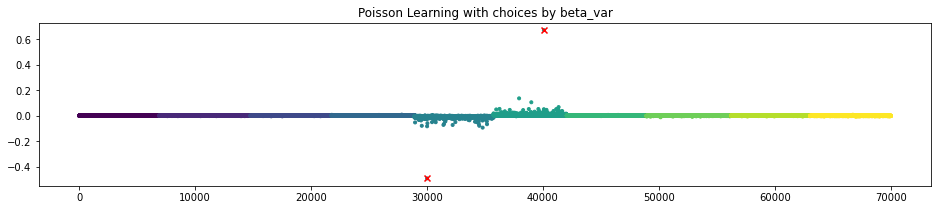

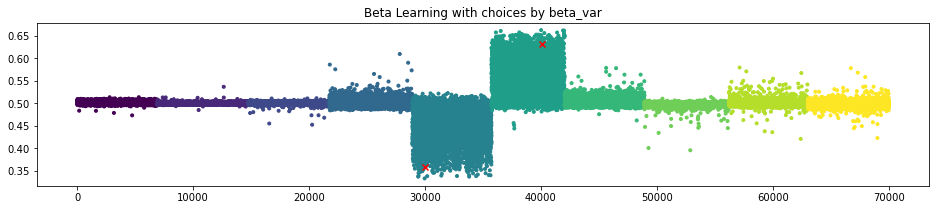

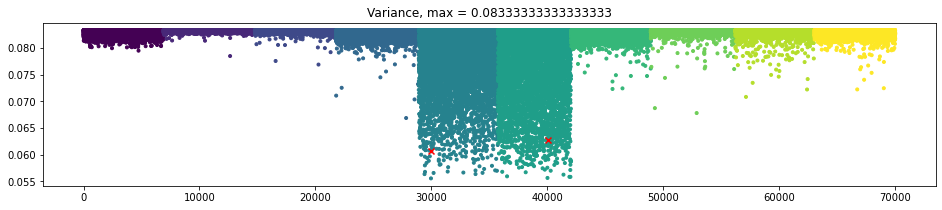

--------------------------------------------------


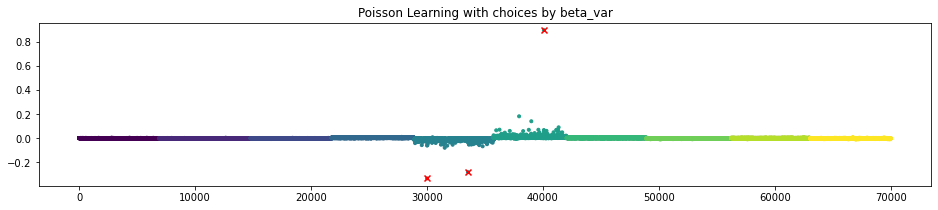

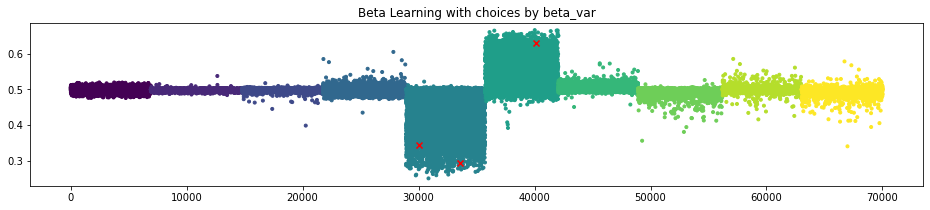

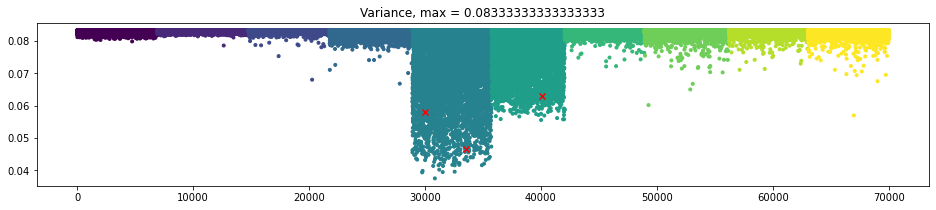

--------------------------------------------------


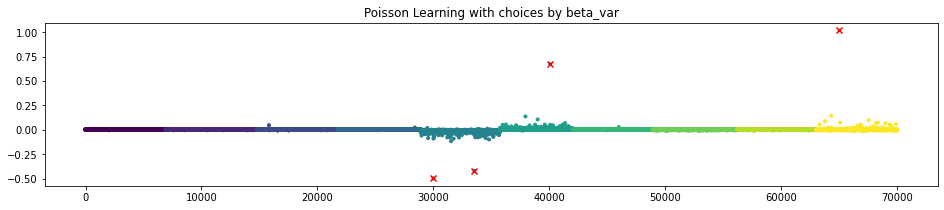

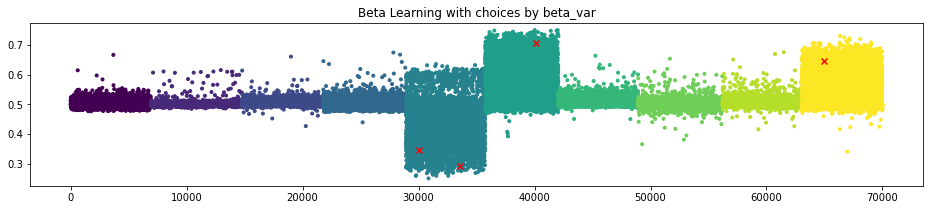

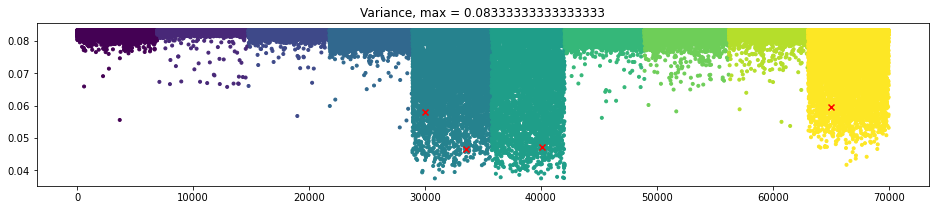

--------------------------------------------------


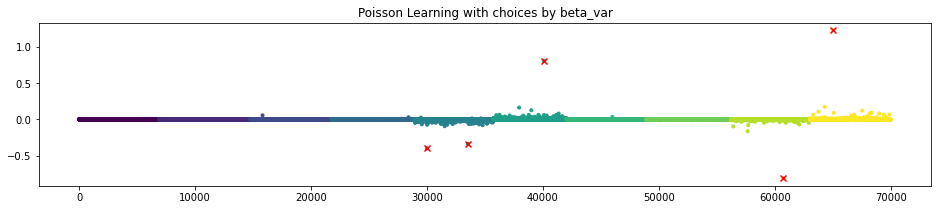

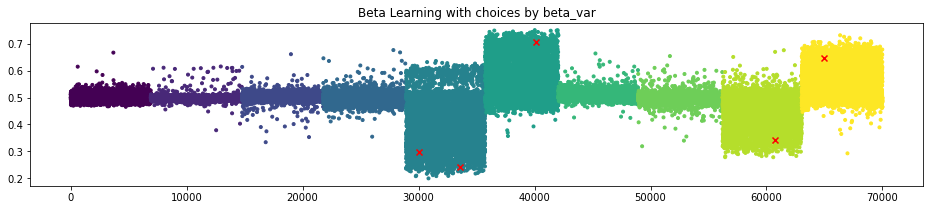

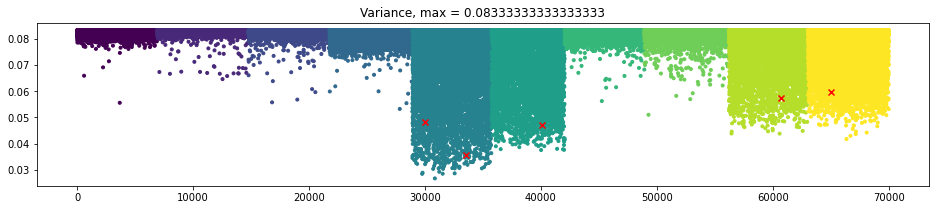

--------------------------------------------------


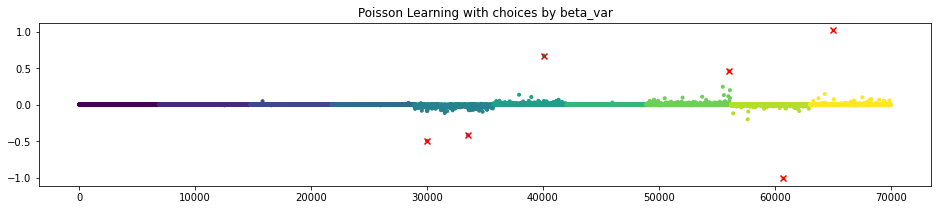

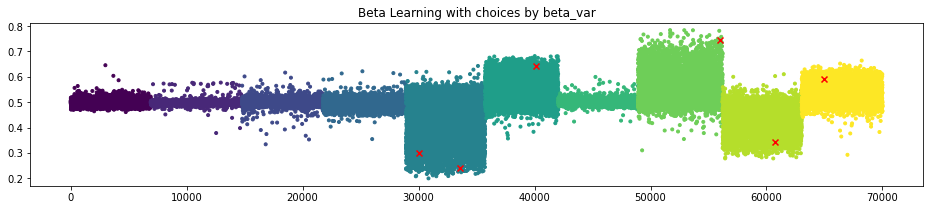

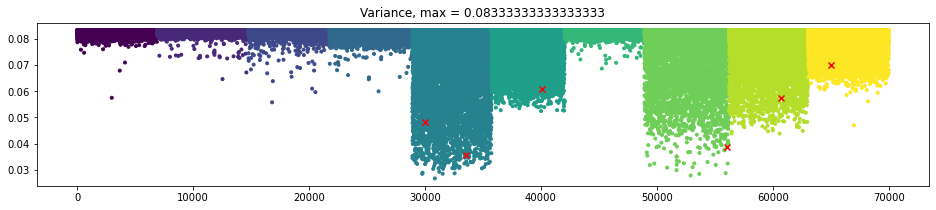

--------------------------------------------------


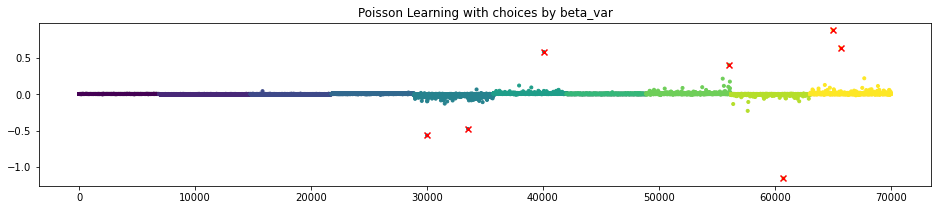

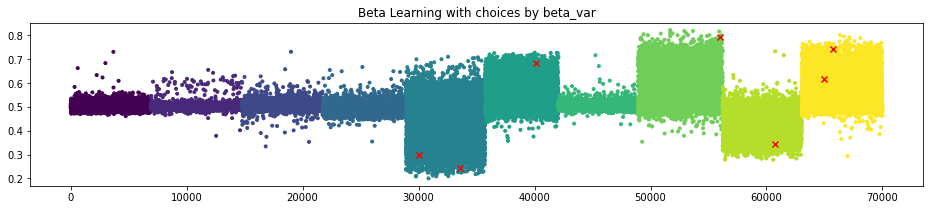

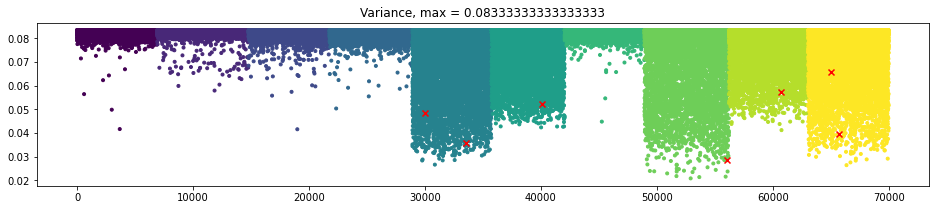

--------------------------------------------------


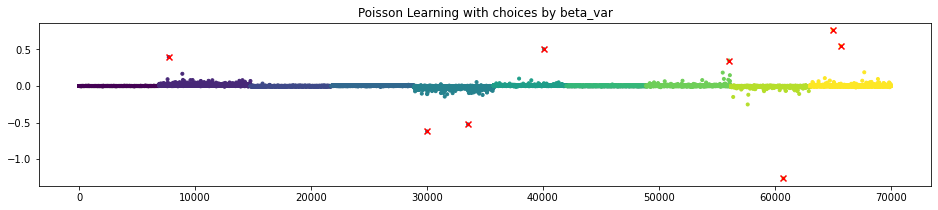

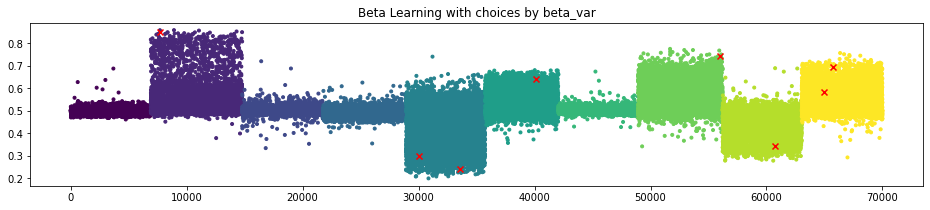

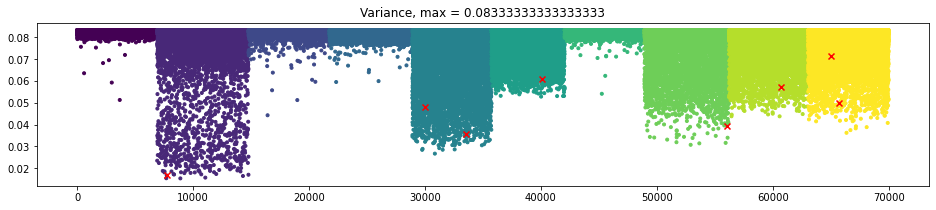

--------------------------------------------------


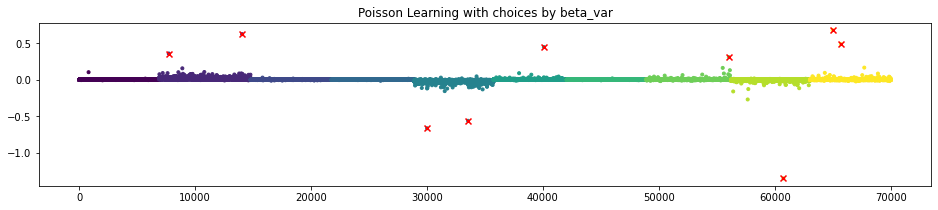

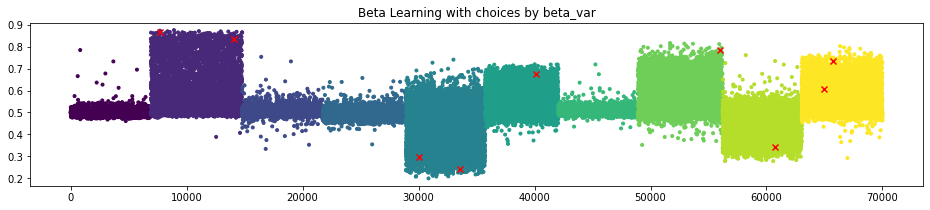

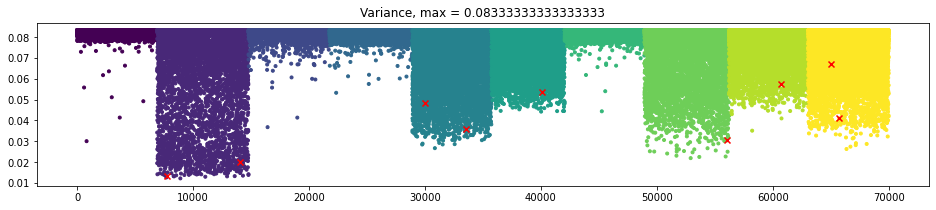

--------------------------------------------------


In [60]:
pl_model = gl.ssl.poisson(G)
acq_func_name = 'beta_var'
all_labeled_ind = query_choices_df[f'{acq_func_name}_choices'].values
start_idx, end_idx = 2, 10

%matplotlib inline

for i in range(start_idx, end_idx):
    train_ind = all_labeled_ind[:i]
    sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]
    
    u = pl_model.fit(train_ind, labels[train_ind])[:,-1]
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Poisson Learning with choices by {acq_func_name}")
    plt.show()
    
    c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
    alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
    u = (alpha+1.)/(alpha + beta+2.)
    u[np.isnan(u)] = 0.5 + 0.0001*np.random.randn(np.isnan(u).sum())
    
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Beta Learning with choices by {acq_func_name}")
    plt.show()
    
    dom = np.arange(u.size)
    u = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Variance, max = {np.max(u)}")
    plt.show()
    print("-"*50)

#### Code to Obtain the Above Plots

In [43]:
def get_poisson_acc(W, labels, start_ind, chosen_inds):
    model = gl.ssl.poisson(W)
    pred_labels = model.fit_predict(start_ind, labels[start_ind])
    acc = np.array([])
    acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, start_ind.size))
    
    for i, idx in enumerate(chosen_inds):
        inds = np.concatenate((start_ind, chosen_inds[:i+1]))
        pred_labels = model.fit_predict(inds, labels[inds])
        acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, inds.size))
    
    return acc

def compute_beta_model(evecs, evals, train_ind, ti_labels):
    c0_ind, c1_ind = train_ind[ti_labels == 0], train_ind[ti_labels == 1]
    alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
    p = (alpha+1.)/(alpha + beta+2.)
    p[p == 0.5] += 0.00001*np.random.randn((p==0.5).sum())
    return p

def get_beta_acc(evecs, evals, labels, start_ind, chosen_inds):
    p = compute_beta_model(evecs, evals, start_ind, labels[start_ind])
    pred_labels = 1.*(p >= 0.5)
    
    acc = np.array([])
    acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, start_ind.size))
    
    for i, idx in enumerate(chosen_inds):
        inds = np.concatenate((start_ind, chosen_inds[:i+1]))
        p = compute_beta_model(evecs, evals, inds, labels[inds])
        pred_labels = 1.*(p >= 0.5)
        acc = np.append(acc, gl.ssl.ssl_accuracy(pred_labels, labels, inds.size))
    
    return acc

In [44]:
beta_var_acc_beta, beta_var_labeled_ind, beta_var_acc_poisson = al_test(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('beta var done')
beta_deg_var_acc_beta, beta_deg_var_labeled_ind, beta_deg_var_acc_poisson = al_test(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='deg-var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True, deg=deg)
print('beta deg var done')
vopt_acc_poisson, vopt_labeled_ind = al_test_gl(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='vopt', \
            show=False, gamma=0.5, algorithm='poisson')
print('vopt done')
poisson_unc_acc_poisson, poisson_unc_labeled_ind = al_test_gl(W, X, labeled_ind, labels, evecs, evals, al_iters=100, method='uncertainty', \
            algorithm='poisson', show=False, gamma=0.5)
print("pl unc done")




return_ll will return poisson learning
beta var done
return_ll will return poisson learning
beta deg var done
vopt done
pl unc done


In [52]:
query_choices = {'beta_var_choices' : beta_var_labeled_ind, 'beta_deg_var_choices': beta_deg_var_labeled_ind,\
                 'vopt_choices' : vopt_labeled_ind, 'poisson_unc_choices' : poisson_unc_labeled_ind}

Beta_accuracies = {'beta_var' : beta_var_acc_beta, 'beta_dvar' : beta_deg_var_acc_beta}
                  
# compute accuracies in beta learning
for name, all_labeled in zip(['vopt', 'poisson_unc'], [vopt_labeled_ind, poisson_unc_labeled_ind]):
    print(name)
    Beta_accuracies[name] = get_beta_acc(evecs, evals, labels, all_labeled[:2], all_labeled[2:])

Poisson_accuracies = {'beta_var' : beta_var_acc_poisson, 'beta_dvar' : beta_deg_var_acc_poisson, \
                'vopt' : vopt_acc_poisson, 'poisson_unc' : poisson_unc_acc_poisson}


poisson_df = pd.DataFrame(Poisson_accuracies)
beta_df = pd.DataFrame(Beta_accuracies)
query_choices_df = pd.DataFrame(query_choices)

poisson_df.to_csv("Lnorm_poisson_acc.csv", index=None)
beta_df.to_csv("Lnorm_beta_acc.csv", index=None)
query_choices_df.to_csv('Lnorm_query_choices.csv', index=None)
np.save("Lnorm_init_labeled.npy", labeled_ind)

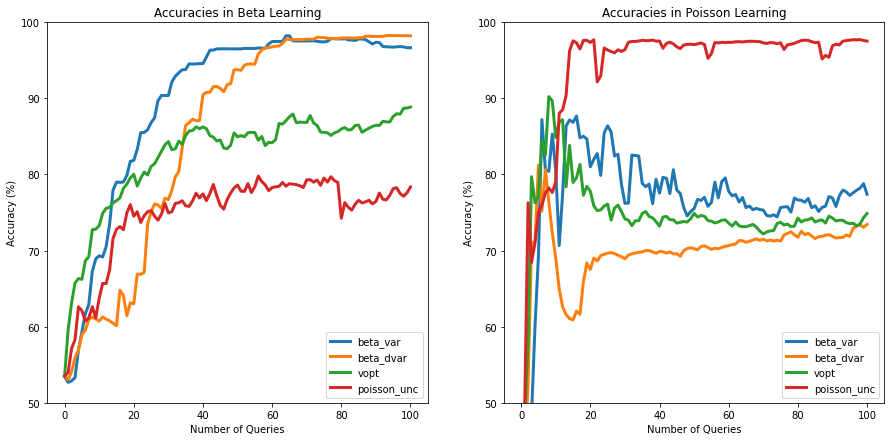

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    beta_df.plot(ax=ax1, title='Accuracies in Beta Learning', linewidth=3.0)
    poisson_df.plot(ax=ax2, title='Accuracies in Poisson Learning', linewidth=3.0)
    ax1.set_xlabel("Number of Queries")
    ax1.set_ylabel("Accuracy (%)")
    ax1.set_ylim(50,100)
    ax1.legend(loc='lower right')
    ax2.set_xlabel("Number of Queries")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_ylim(50,100)
    ax2.legend(loc='lower right')
    plt.show()

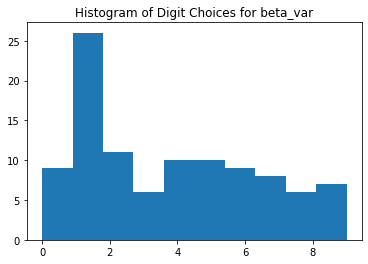

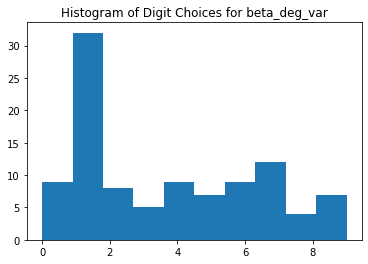

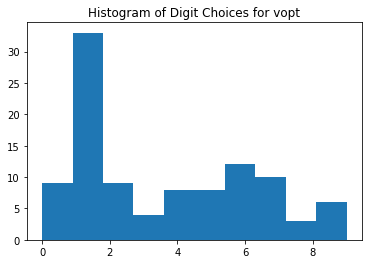

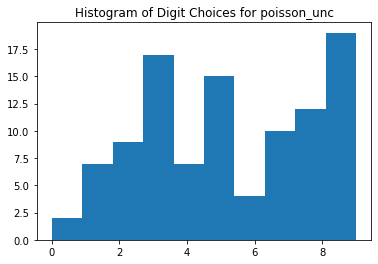

In [53]:
col_choices = [name for name in query_choices_df.columns if "_choices" in name]
for col_name in col_choices:
    name = "_".join(col_name.split("_")[:-1])
    plt.hist(digits[query_choices_df[col_name].values])
    plt.title(f"Histogram of Digit Choices for {name}")
    plt.show()

In [24]:
# old way
# test_results = np.load("Lnormevals_test.npz")
# Poisson_accuracies = {}
# Beta_accuracies = {}
# for name in list(test_results.keys()):
#     print(name)
#     all_labeled = test_results[name]
#     Beta_accuracies[name] = get_beta_acc(evecs, evals, labels, all_labeled[:2], all_labeled[2:])
#     Poisson_accuracies[name] = get_poisson_acc(W, labels, all_labeled[:2], all_labeled[2:])
    

vopt_labeled
llu_labeled
plu_labeled


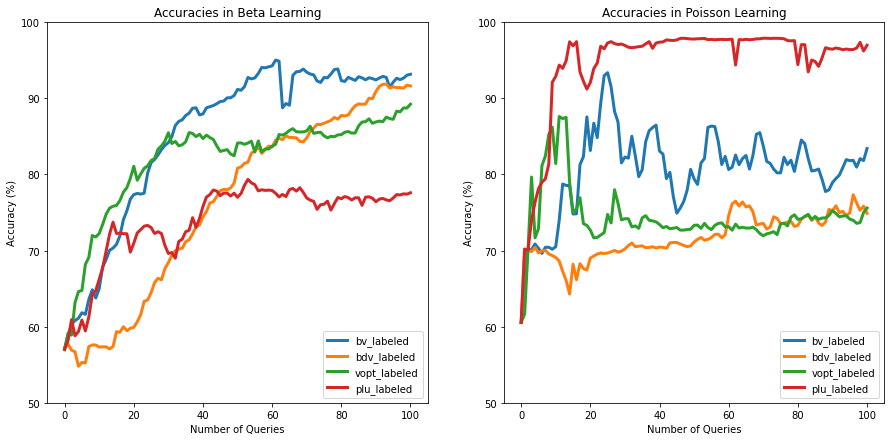

In [42]:
# old plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
beta_df[['bv_labeled', 'bdv_labeled', 'vopt_labeled', 'plu_labeled']].plot(ax=ax1,\
                                        title='Accuracies in Beta Learning', linewidth=3.0)
poisson_df[['bv_labeled', 'bdv_labeled', 'vopt_labeled', 'plu_labeled']].plot(ax=ax2, \
                                        title='Accuracies in Poisson Learning', linewidth=3.0)
ax1.set_xlabel("Number of Queries")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(50,100)
ax1.legend(loc='lower right')
ax2.set_xlabel("Number of Queries")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(50,100)
ax2.legend(loc='lower right')
plt.show()

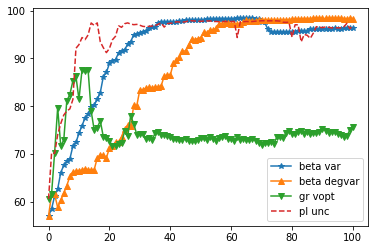

In [324]:
dom = np.arange(beta_var_acc_.size)
plt.plot(dom, beta_var_acc_, '-*', label='beta var', linewidth=1.5)
plt.plot(dom, beta_deg_var_acc_, '-^', label='beta degvar', linewidth=1.5)
plt.plot(dom, vopt_acc_, '-v', label='gr vopt', linewidth=1.5)
# plt.plot(dom, uncertainty_acc_, '-o', label='ll unc', linewidth=1.5)
plt.plot(dom, poisson_uncertainty_acc_, '--', label='pl unc', linewidth=1.5)
plt.legend()
plt.show()

In [313]:
print(labels[beta_var_labeled_ind])
print(labels[poisson_uncertainty_labeled_ind])

[0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0
 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0
 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0]
[0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0
 0 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1]


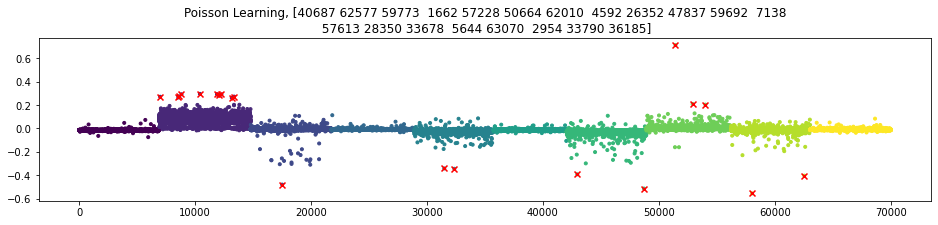

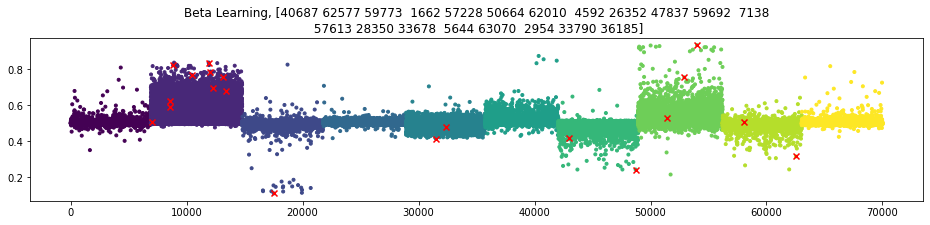

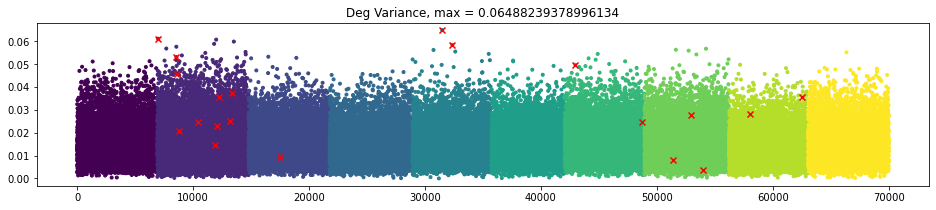

--------------------------------------------------


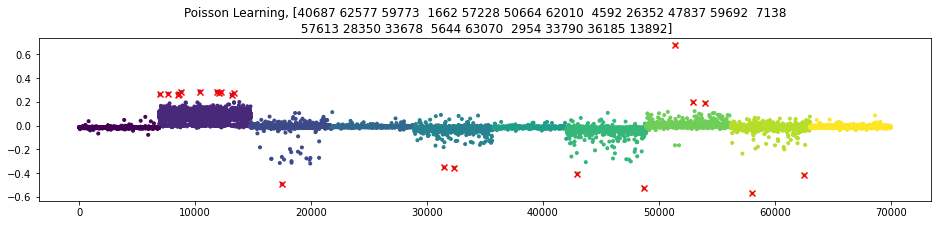

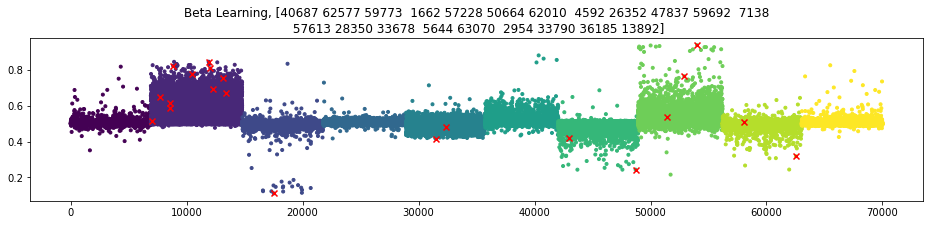

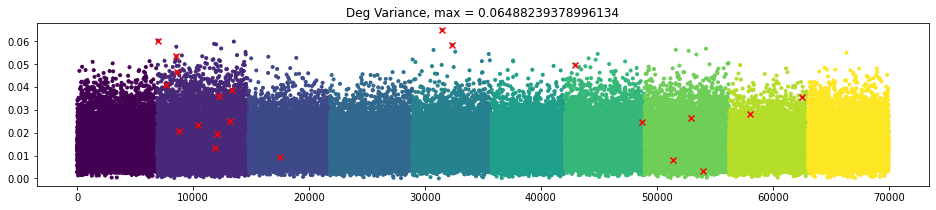

--------------------------------------------------


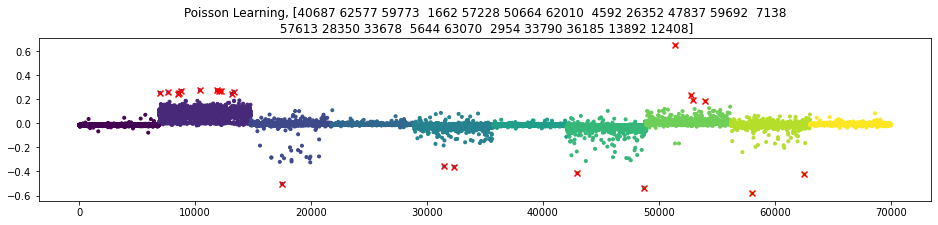

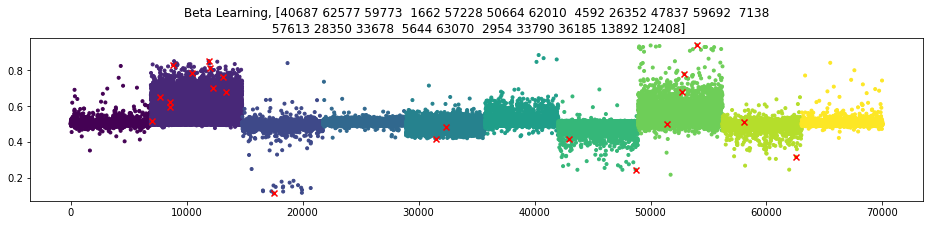

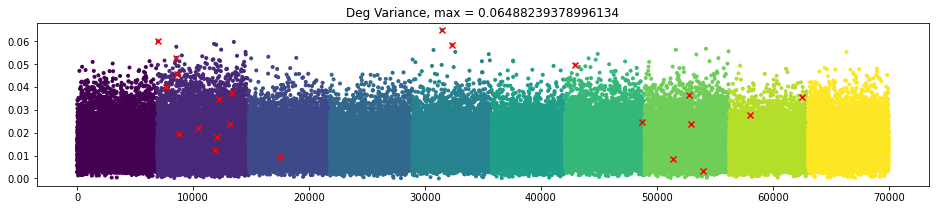

--------------------------------------------------


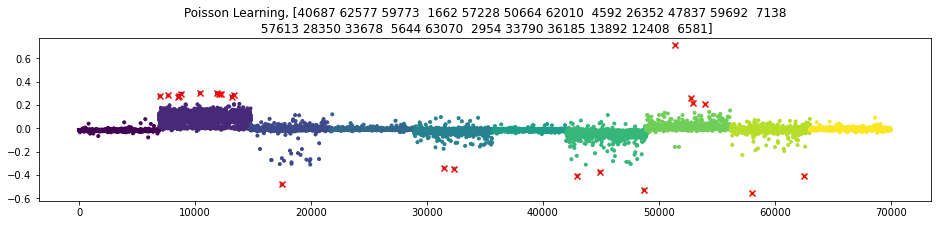

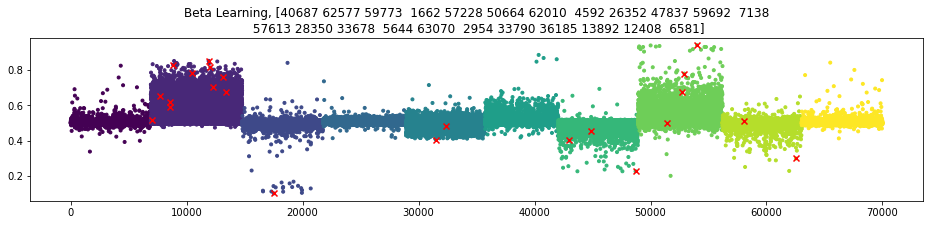

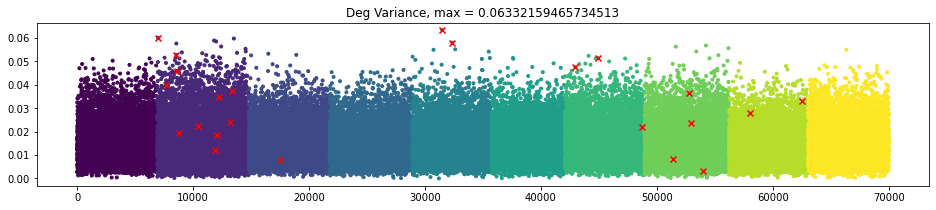

--------------------------------------------------


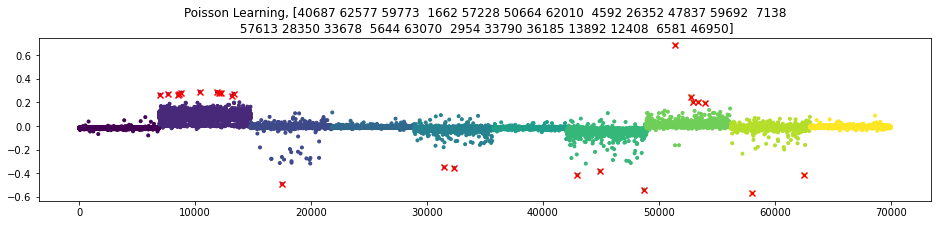

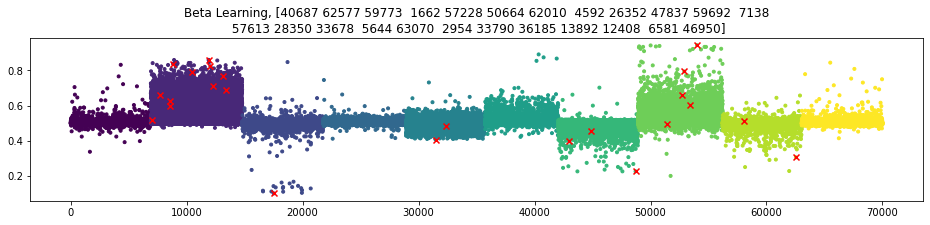

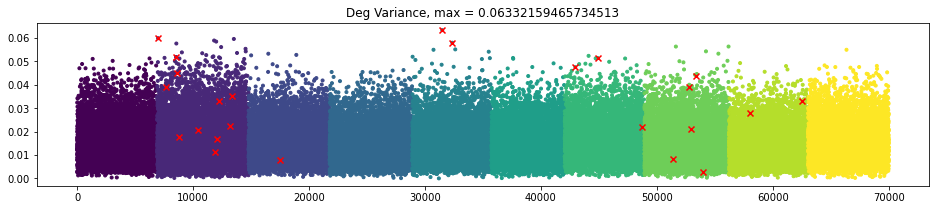

--------------------------------------------------


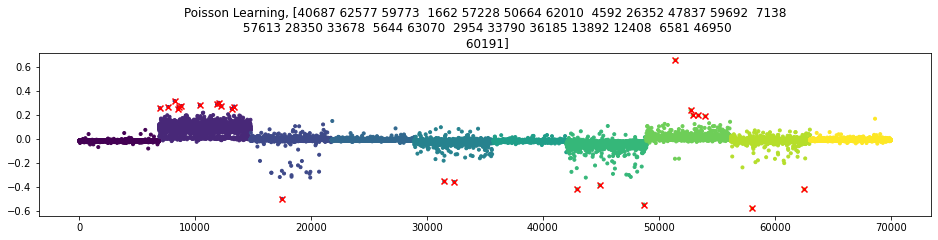

KeyboardInterrupt: 

In [326]:
pl_model = gl.ssl.poisson(G)
all_labeled_ind = beta_deg_var_labeled_ind
%matplotlib inline

for i in range(20, 30):
    train_ind = all_labeled_ind[:i]
    sorted_train_ind = np.where(np.isin(digit_sorted_idx, train_ind))[0]
    
    u = pl_model.fit(train_ind, labels[train_ind])[:,-1]
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Poisson Learning, {train_ind}")
    plt.show()
    
    c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
    alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .1, thresh=1e-9)
    u = (alpha+1.)/(alpha + beta+2.)
    u[np.isnan(u)] = 0.5 + 0.0001*np.random.randn(np.isnan(u).sum())
    
    dom = np.arange(u.size)
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Beta Learning, {train_ind}")
    plt.show()
    
    dom = np.arange(u.size)
    u = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
    u *= deg
    fig, ax = plt.subplots(figsize=(16,3))
    ax.scatter(dom, u[digit_sorted_idx], marker='.', c=digits[digit_sorted_idx])
    ax.scatter(sorted_train_ind, u[digit_sorted_idx][sorted_train_ind], marker='x', c='r')
    ax.set_title(f"Deg Variance, max = {np.max(u)}")
    plt.show()
    
# #     u = (alpha + 1.)*(beta + 1.)/((alpha + beta + 2.)**2. * (alpha + beta + 3.))
#     dom = np.arange(u.size)
#     fig, ax = plt.subplots(figsize=(16,3))
#     ax.scatter(dom, u, marker='.', c=digits)
#     ax.scatter(train_ind, u[train_ind], marker='x', c='r')
#     ax.set_title(f"Variance (Not Ordered), {train_ind}")
# #     ax.set_xlim(-1,10)
#     plt.show()
    print("-"*50)

## Next Ideas

* Poisson weighting of "properly weighted" Laplace learning is much like the propagation we're looking for with Beta learning. Want to try that -- for the columns alpha and beta. Should be straightforward to compute variance, and we don't need to worry about eigenvalues and eigenvectors up front (unless we're looking to do some look-ahead stuff...)
* seems like the look-ahead stuff anyway is just too computationally intensive -- though, I could look at how to optimize the code more
    * the look-ahead (model change or vopt) didn't seem to do very well in the toy examples even... 
    * maybe the point we can make in both Beta Learning and what I'm doing with Jeff is : __instead of designing a better acquisition function, design a better (and still simple) graph-based model for which uncertainty sampling does exactly what we want it to!__ (and we have some guarantee?)